In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from TCGA_files import *
from gtex import get_gtex_tissue
import seaborn as sns
import sys, os
from hsbmpy import topic_distr_isample, topic_distr_sample,get_file, get_tissue_style, get_max_available_L
from TCGA_files import get_tcga_tissue

In [212]:
label=""
algorithm = "lda"
directory='/home/jovyan/work/phd/datasets/paper/gtexhk/'
L = get_max_available_L(directory, algorithm)
os.chdir(directory)

In [213]:
df = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L))
df.head()

,i_doc,doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 41,Topic 42,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49,Topic 50
0,0,GTEX-111CU-1426-SM-5GZYP,0.020088,0.019955,0.019989,0.020001,0.019981,0.019875,0.020017,0.019842,...,0.020002,0.020060,0.020026,0.020048,0.019983,0.019990,0.019936,0.020007,0.020048,0.019936
1,1,GTEX-111FC-0226-SM-5N9B8,0.020031,0.020050,0.019917,0.020059,0.019974,0.019966,0.020045,0.020054,...,0.020039,0.019876,0.020002,0.019976,0.020079,0.019979,0.019925,0.019978,0.020011,0.020002
2,2,GTEX-111YS-0006-SM-5NQBE,0.020162,0.020210,0.020236,0.019767,0.019779,0.020074,0.019786,0.020015,...,0.019987,0.020353,0.019618,0.020313,0.019904,0.020052,0.019963,0.020074,0.019875,0.020139
3,3,GTEX-111YS-0326-SM-5GZZ3,0.020030,0.020024,0.020130,0.019900,0.019984,0.020046,0.020085,0.019994,...,0.020016,0.020069,0.020007,0.019980,0.020012,0.020016,0.019985,0.019998,0.020103,0.019908
4,4,GTEX-111YS-2426-SM-5GZZQ,0.020038,0.019996,0.019963,0.020051,0.020005,0.019965,0.019996,0.020035,...,0.020060,0.019951,0.019994,0.020026,0.020050,0.019956,0.019917,0.019968,0.020022,0.019935


### Specific topic

In [ ]:
topic = 15

In [ ]:
searchdf = df.sort_values(by="Topic %d"%topic, ascending=False).loc[:,['doc','Topic %d'%topic]]
searchdf.head()

In [ ]:
#datatotest = queryFiles([f[0]+'.FPKM.txt.gz' for f in searchdf.values[:30] if f[1]>0.1])
#datatotest = queryFiles([f[0] for f in searchdf.values[:10]])
datatotest = pd.DataFrame(columns=['primary_site','secondary_site'])
for file in [f[0] for f in searchdf.values[:10]]:
    datatotest=datatotest.append(get_gtex_tissue(file))
datatotest

In [ ]:
makeTopicPie(datatotest, L, ['primary_site','secondary_site'])

In [ ]:
df_file=pd.read_csv("files.dat", index_col=[0])
samples = []
for sample in df['doc']:
    if 'Lung' in get_gtex_tissue(sample)['primary_site']:
        samples.append(sample)

In [ ]:
tissuedf = df[df['doc'].isin(samples)].drop('i_doc', axis=1)
tissuedf.mean(axis=0).sort_values(ascending=False)

## topic distr

In [ ]:
for idoc in searchdf.index.values[:5]:
    fig=plt.figure()
    ax=fig.subplots()
    topic_distr_isample(idoc,df,ax)
    plt.show()
    fig.savefig("topic_distr_%d.png"%idoc)

In [ ]:
for idoc in np.random.randint(len(df.index), size=10):
    topic_distr_isample(idoc, df)

## Topic distr

### kl

In [67]:
l=L-1

In [ ]:
df_kl = pd.read_csv("%s/topsbm/topic-kl_%d.csv"%(directory,l), header=None)
df_kl.columns = ['first', 'second', 'kl']
df_kl.head()

In [ ]:
df_cluster = pd.read_csv("%s/topsbm/topsbm_level_%d_clusters.csv"%(directory,l))
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l)).loc[:,df.columns[2:]]
df_files = pd.read_csv("%s/files.dat"%(directory), index_col=[0], header=0)

In [ ]:
bins = np.linspace(-0.025,1.025,40)

In [ ]:
sites = df_files[label].unique()
df_tissue_kl = pd.DataFrame(index=sites, columns=sites, dtype=float)

In [ ]:
for tissue_row in sites:
    cluster_row = df_files[df_files['primary_site']==tissue_row].index.values
    for tissue_column in sites:
        print(tissue_row, tissue_column)
        cluster_column = df_files[df_files['primary_site']==tissue_column].index.values
        datarc = df_kl[(df_kl['first'].isin(cluster_row) & df_kl['second'].isin(cluster_column))]['kl'].values
        datacr = df_kl[(df_kl['first'].isin(cluster_column) & df_kl['second'].isin(cluster_row))]['kl'].values
        df_tissue_kl.at[tissue_row,tissue_column]=(np.average(np.concatenate((datarc,datacr))))

In [ ]:
h = sns.clustermap(df_tissue_kl.dropna(axis=0,how='all').dropna(axis=1, how='any'), cmap=sns.diverging_palette(15,250, n=15), metric='euclidean')
dn = h.dendrogram_col.dendrogram
h.fig.savefig("%s/topic_distr_kl_map.pdf"%directory)

In [ ]:
import scipy.cluster.hierarchy as shc
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.set_xlabel("kl correlation", fontsize=16)
dend = shc.dendrogram(h.dendrogram_col.linkage, labels=df_tissue_kl.columns, orientation='right', distance_sort='discending', ax=ax)
fig.savefig("%s/topic_dist_dendogram_level(%d).pdf"%(directory,l))

### Topic maps

In [216]:
l=L-1

In [217]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,l))
t_size = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,l), index_col=0).apply(lambda topic: sum((topic>0).astype(int))).mean()
df_files = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
label = "SMTS"
if label not in df_files.columns:
    raise AttributeError(f"{label} not valid. Available: {df_files.columns}")
print("Working with %d topics and average size: %d"%(df_topics.shape[1]-1, round(t_size)))

Working with 38 topics and average size: 2999


In [218]:
for sample in df_topics.index.values:
    try:
        df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)[label]))
    except:
        print(*sys.exc_info())
        print(sample)
        df_topics.at[sample,'tissue']="unknown"

In [219]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
df_cmap = df_cmap.subtract(df_cmap.mean(axis=1),axis=0)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

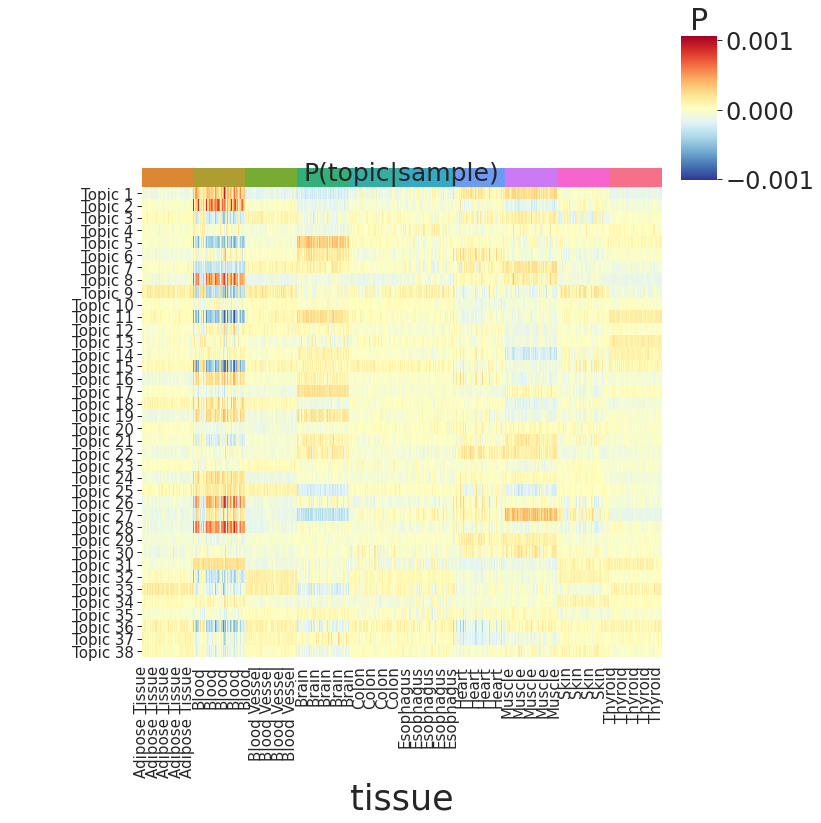

In [220]:
cm = sns.clustermap(df_cmap, 
                    row_cluster=False, 
                    col_cluster=False, 
                    metric='euclidean',  
                    cmap='RdYlBu_r', 
                    col_colors=network_col,
                    cbar_pos=(0.95,0.8,0.05,0.2)
                    )
ax = cm.ax_heatmap

ax.tick_params(labelsize=15)
ax.set_xlabel("tissue", fontsize=35)
ax.set_title("P(topic|sample)", fontsize=25)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
#ax.set_yticklabels(df_cmap.index, rotation=0)


cax = cm.ax_cbar
cax.tick_params(labelsize=24)
cax.set_title("P", fontsize=30)
cm.fig.savefig("%s/MAP_level%d.pdf"%(algorithm,l))

In [66]:
topic = "Topic 10"
df_single_topic = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,l), index_col=0).sort_values([topic], ascending=False)[topic].dropna()
for g in df_single_topic[df_single_topic>df_single_topic[df_single_topic>0].quantile(0.)].index:
    print(g[:15])

ENSG00000142541
ENSG00000105193
ENSG00000174444
ENSG00000118181
ENSG00000083845
ENSG00000254772
ENSG00000074800
ENSG00000137409
ENSG00000143878
ENSG00000089009
ENSG00000136942
ENSG00000122406
ENSG00000171858
ENSG00000161970
ENSG00000178719
ENSG00000108654
ENSG00000068697
ENSG00000114942
ENSG00000104852
ENSG00000108344
ENSG00000141232
ENSG00000185883
ENSG00000189043
ENSG00000198034
ENSG00000181163
ENSG00000108518
ENSG00000134333
ENSG00000100201
ENSG00000117984
ENSG00000128272
ENSG00000137154
ENSG00000100129
ENSG00000111640
ENSG00000179218
ENSG00000110651
ENSG00000089220
ENSG00000135535
ENSG00000108298
ENSG00000135404
ENSG00000049245
ENSG00000071127
ENSG00000105677
ENSG00000179091
ENSG00000100243
ENSG00000111678
ENSG00000110108
ENSG00000167085
ENSG00000141522
ENSG00000087460
ENSG00000157514
ENSG00000132507
ENSG00000169045
ENSG00000110107
ENSG00000105701
ENSG00000009307
ENSG00000178035
ENSG00000115053
ENSG00000164924
ENSG00000125835
ENSG00000111897
ENSG00000148303
ENSG00000111669
ENSG0000

In [221]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
order = df_topics.mean(0).sort_values(ascending=False)
df_topics = df_topics.reindex(columns=order.index)
df_topics.columns = ["Topic %d"%(t+1) for t,_ in enumerate(df_topics.columns)]
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)[label])

Adipose Tissue
Blood
Blood Vessel
Brain
Colon
Esophagus
Heart
Muscle
Skin
Thyroid


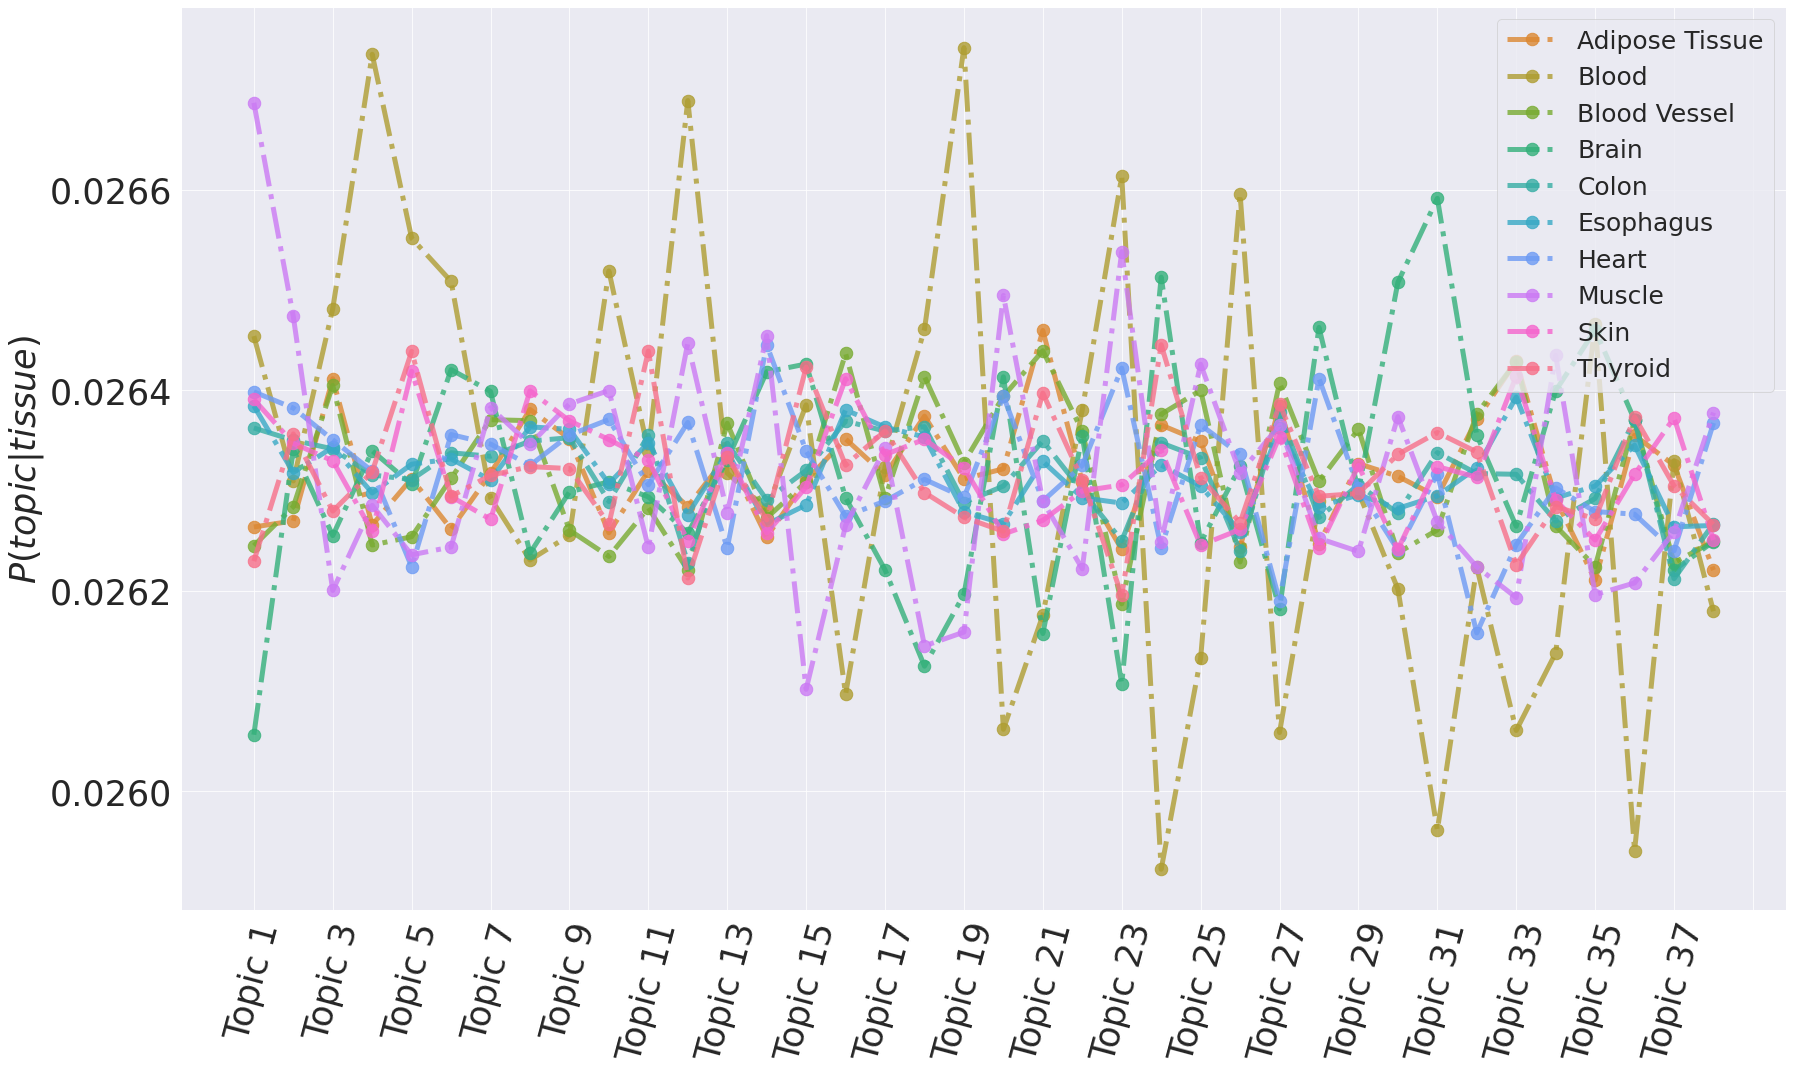

In [222]:
fig,ax = plt.subplots(figsize=(25,15))
for tissue in np.sort(df_topics['tissue'].unique()):
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        df_topics[df_topics['tissue']==tissue].mean(axis=0).plot(ls=ls,marker=marker, lw=5, ms=25, alpha=0.8, ax=ax, label=tissue, c=network_lut[tissue])
    except:
        print(*sys.exc_info())
ax.set_ylabel("$P(topic | tissue)$", fontsize=35)
#plt.xscale('log')
#plt.yscale('log')

ax.set_xticks(np.arange(0, df_topics.shape[1],step=2))
ax.set_xticklabels(df_topics.columns[:-1:2], rotation=75)
ax.tick_params(labelsize=35)


# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(fontsize=25, ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(fontsize=25, ncol=1, loc='best')

plt.tight_layout()
plt.show()
fig.savefig("%s/lifeplot_level%d.pdf"%(algorithm,l))

In [223]:
import tensorflow as tf

In [224]:
label = "SMTS"
df_files_pd = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,l))
df_files = pd.read_csv("files.dat")
df_topics.insert(0,"status",['healthy' if 'GTEX' in x else 'tumour' for x in df_topics["doc"]])
df_topics.insert(0,'tissue',[get_file(x, df_files_pd)[label] if get_file(x, df_files_pd) is not None else np.nan for x in df_topics["doc"]])

In [225]:
df_topic_list = pd.read_csv("%s/%s_level_%d_topics.csv"%(algorithm,algorithm,l))

### only health vs disease

In [ ]:
dftf_h = tf.convert_to_tensor(df_topics[df_topics["status"]=="healthy"].drop(['doc','i_doc', 'status', 'tissue'], axis=1).astype(float).values)
dftf_d = tf.convert_to_tensor(df_topics[df_topics["status"]=="tumour"].drop(['doc','i_doc', 'status', 'tissue'], axis=1).astype(float).values)

In [ ]:
results = tf.sort([tf.math.reduce_mean(dftf_h,0),tf.math.reduce_mean(dftf_d,0)], axis=1, direction='DESCENDING').numpy()

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(results[0], marker='o', lw=0.1)
plt.plot(results[1],marker='x', lw=0.1)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
df_topics.groupby('tissue').count()

In [ ]:
for topic in topic_cols:
    plt.figure(figsize=(15,8))
    plt.title(topic)
    for tissue in df_topics.select('second_tissue').distinct().toPandas().values.T[0]:
        tissue_spec=(df_topics.filter(col('second_tissue')==tissue).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
        plt.hist(tissue_spec.values.T[0], density=True, histtype='step', label=tissue)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [ ]:
df_topics_grouped = df_topics.groupby('second_tissue').agg({x: 'avg' for x in topic_cols}).toPandas().set_index('second_tissue')[["avg(%s)"%t for t in topic_cols]].transpose()
df_topics_grouped.index=topic_cols

In [ ]:
df_cmap = df_topics_grouped
df_cmap=df_cmap.subtract(df_cmap.mean(axis=1), axis=0).divide(df_cmap.std(axis=1), axis=0)
df_cmap.sort_index(axis=1, inplace=True)
#df_cmap.sort_values(by=[c for c in df_cmap.columns[::2]], inplace=True)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', cmap='RdYlBu', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

In [ ]:
fig=plt.figure(figsize=(10,8))
#plt.plot((df_tissue).values[0], label=look_for[0], ls='--', ms=10)
plt.hist((df_tissue_healthy).values[0], label=look_for[1], marker='x', lw=0.5, ms=10)
plt.hist((df_tissue_disease).values[0], label=look_for[2], marker='x', lw=0.5, ms=10)
plt.xticks(ticks=np.arange(len(topic_cols)), labels=topic_cols, rotation=90)
#plt.yscale('log')
plt.legend(fontsize=20)
plt.show()

In [ ]:
(df_tissue_healthy-df_tissue).values

### all

In [226]:
df_all = tf.convert_to_tensor(df_topics.drop(['i_doc', 'doc', 'status', 'tissue'], axis=1).astype(float).values)

In [230]:
normed_df = tf.subtract(df_all,tf.reduce_mean(df_all,0),0)
#normed_df = tf.divide(tf.abs(tf.subtract(df_all,tf.reduce_mean(df_all,0))),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
#normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
#normed_df = tf.divide(tf.math.divide(df_all,tf.reduce_mean(df_all,0)), tf.cast(tf.shape(df_all)[0], tf.float64))
#normed_df = tf.math.multiply(df_all,tf.reduce_mean(df_all,0))

In [231]:
result = normed_df.numpy()

Colon
Adipose Tissue
Blood
Heart
Blood Vessel
Skin
Muscle
Thyroid
Brain
Esophagus


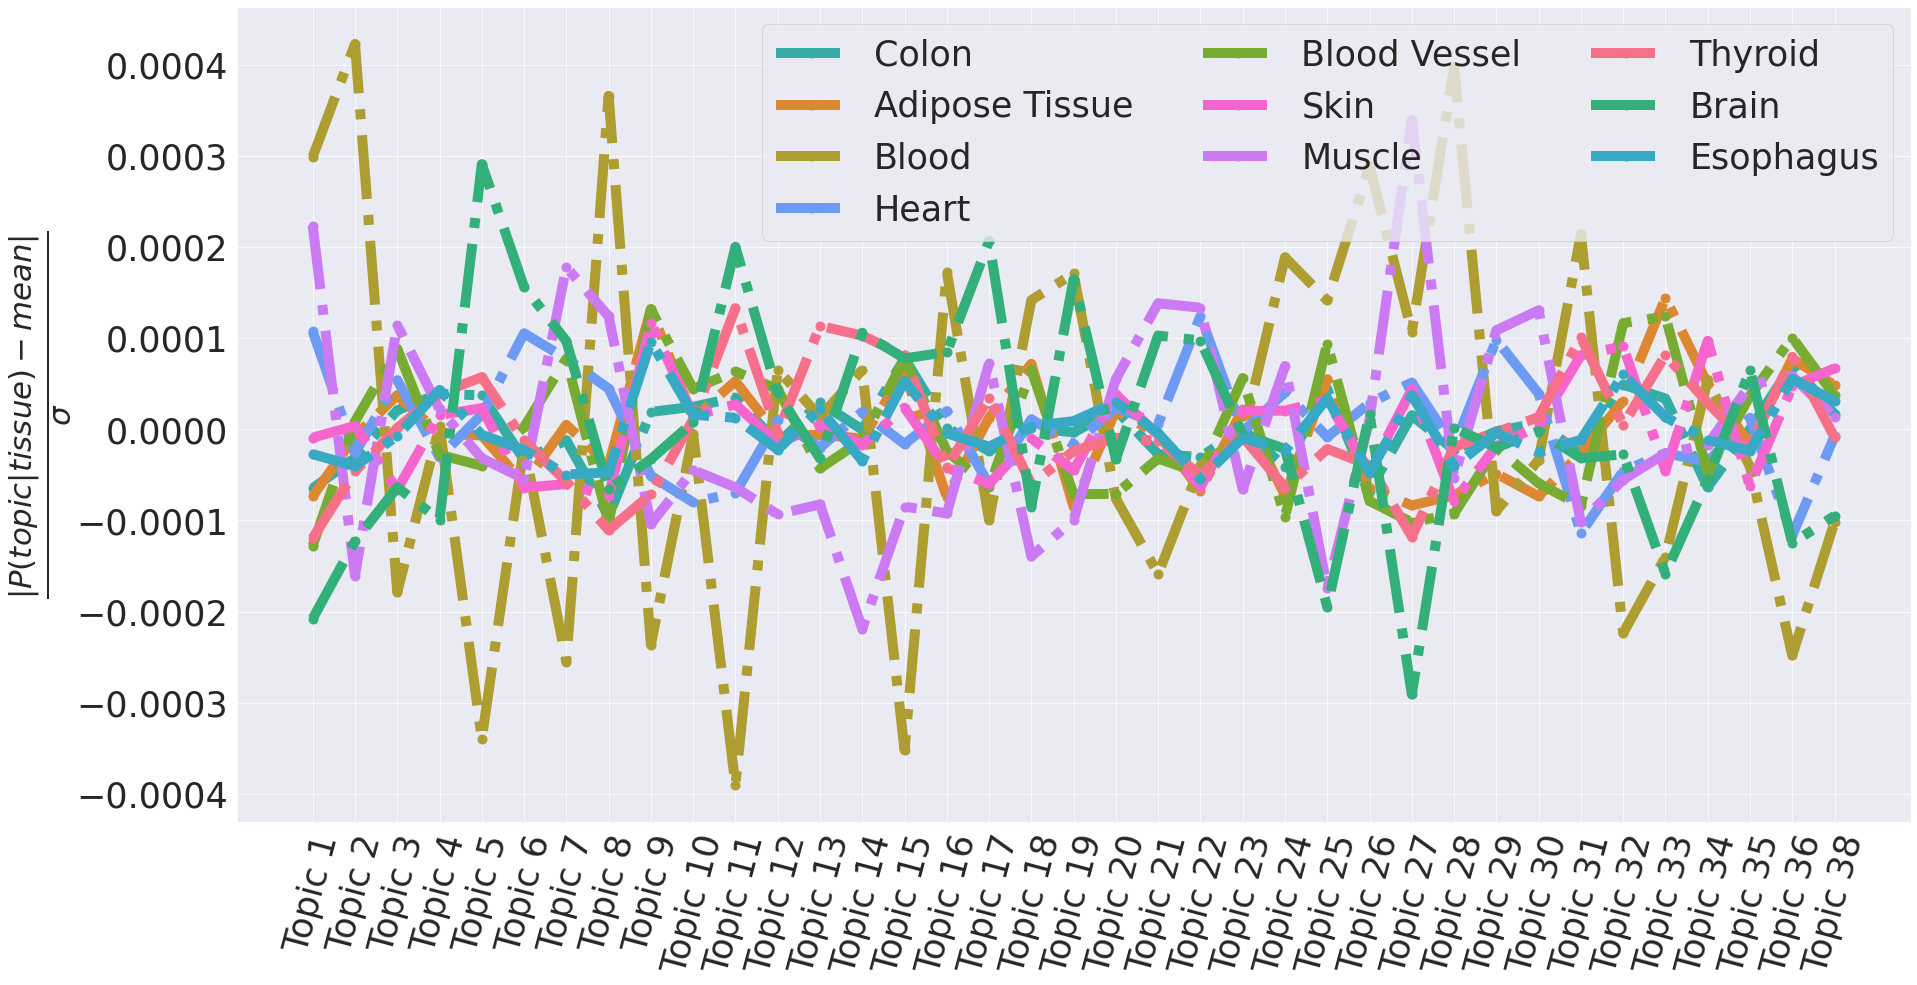

In [232]:
fig=plt.figure(figsize=(30,15))
topics_i = np.linspace(0,df_all.shape[1]-1,df_all.shape[1]-1, dtype=int)
label = 'tissue'
for tissue in df_topics['tissue'].unique():
    print(tissue)
    if tissue is None:
        continue
    marker, c, ls = get_tissue_style(tissue)
    c = network_lut[tissue]
    i_docs = df_topics[df_topics['tissue']==tissue]["i_doc"].values.astype(int)
    plt.plot(np.mean(result[i_docs],axis=0)[topics_i], marker=marker, lw=10, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
plt.legend(fontsize=35, ncol=3)
plt.ylabel("$\\frac{\\left|P(topic | tissue) - mean\\right|}{\sigma}$", fontsize=44)
plt.xticks(np.linspace(0,len(topics_i)-1,num=len(topics_i)), ["Topic %d"%(t+1) for t in topics_i], rotation=75, fontsize=24)
plt.tick_params(labelsize=35)
#plt.yscale('log')
plt.show()
fig.savefig("%s/%s/lifeplot_normalised_level%d.pdf"%(directory,algorithm,l))

Colon


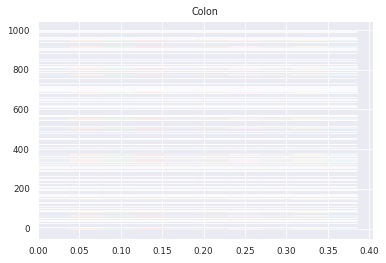

Adipose Tissue


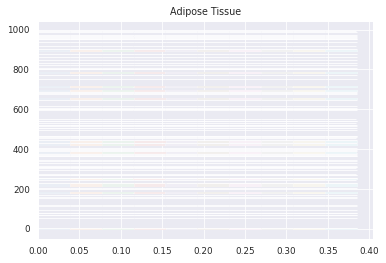

Blood


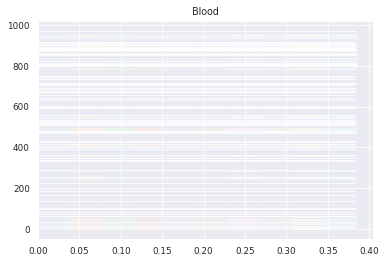

Heart


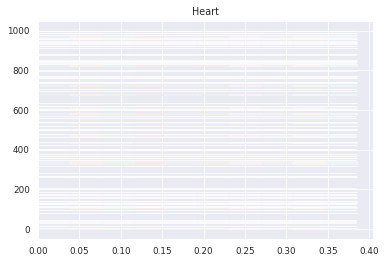

Blood Vessel


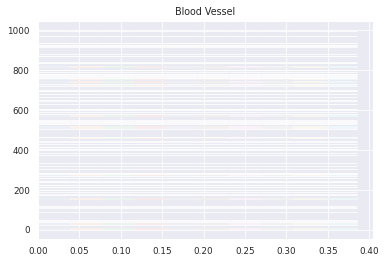

Skin


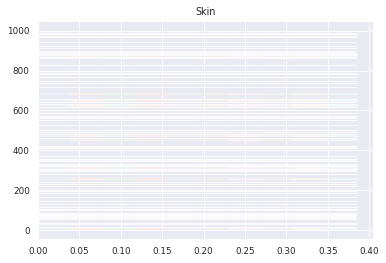

Muscle


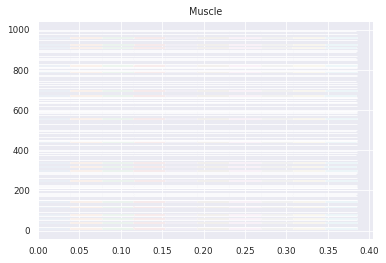

Thyroid


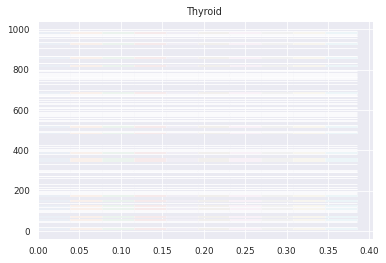

Brain


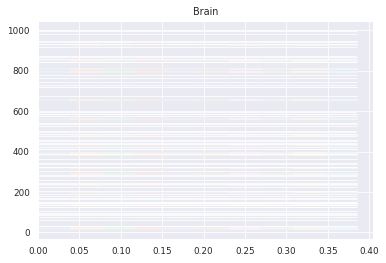

Esophagus


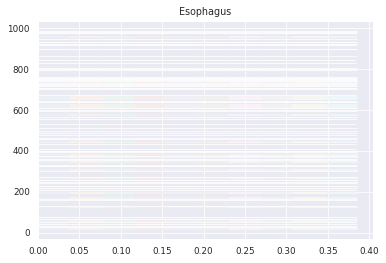

In [94]:
for tissue in df_topics['tissue'].unique():
    print(tissue)
    fig=plt.figure()
    plt.title(tissue)
    df_visual = df_topics[df_topics['tissue']==tissue].drop(['i_doc', 'doc', 'status', 'tissue'], axis=1).astype(float)
    width = np.zeros(len(df_visual.index))
    for t in df_visual.columns:
        plt.barh(df_visual.index.values,df_visual[t].values,left=width)
        width+=df_visual[t].values
    plt.show()
    fig.savefig("%s/topicvisual_%s.png"%(algorithm,tissue))